In [1]:
import drjit as dr
import matplotlib.pyplot as plt
import mitsuba as mi
from pathlib import Path
from tqdm import tqdm
from typing import List

mi.set_variant('cuda_ad_rgb')

from mimt import *

In [2]:
def create_scene(integrator: str):
    scene_dict = mi.cornell_box()

    scene_dict['integrator']['type']      = integrator
    scene_dict['integrator']['max_depth'] = 5 # limit moderate depth
    scene_dict['sensor']['film']['sample_border'] = True

    # Remove the boxes and add a custom shape
    del scene_dict['large-box']
    del scene_dict['small-box']
    scene_dict['shape'] = {
        'type': 'sphere',
        'radius': 0.5,
        'bsdf': {
            'type': 'roughplastic',
            'diffuse_reflectance': {
                'type': 'rgb',
                'value': [1, 0.6, 0.1]
            }
        }
    }

    return scene_dict

def apply_transform(params: mi.SceneParameters, original: mi.Transform4f, offset: float):
    params['shape.to_world'] = mi.Transform4f().translate([0, 0, -offset]) @ original
    params.update()
    return params

In [3]:
def generate_data(integrators: List[str], spp: int, spp_grad: int):
    data = {}

    # Generate the data for the gi
    data['cornell'] = []
    for integrator in (pbar:= tqdm(integrators, leave=False, desc="integrator")):
        tqdm.write("    "+integrator)
        pbar.set_postfix_str(integrator)
        scene = mi.load_dict(create_scene(integrator=integrator.lower()))

        params   = mi.traverse(scene)
        original = mi.Transform4f(params['shape.to_world'])

        # Render primal image
        img = mi.render(scene, params=params, seed=10, spp=spp, spp_grad=spp_grad)

        # Compute gradients
        render_with_offset = lambda x: mi.render(scene, params=apply_transform(params, original, x), seed=0)
        grad_fd = compute_gradient_finite_differences(render_with_offset, 0., h=0.01)
        grad_fw = compute_gradient_forward(render_with_offset, 0.)
        
        data['cornell'].append((integrator, img, grad_fd, grad_fw))

    return data

In [4]:
def generate_figure(integrators: List[str], data: dict, output_path: Path, grad_projection='red'):
    grad_projection_fn = None
    if grad_projection == 'red':
        grad_projection_fn = lambda grad: grad[...,0]
    elif grad_projection == 'mean':
        grad_projection_fn = lambda grad: dr.mean(grad, axis=-1)
    else:
        raise RuntimeError(f"Unknown gradient projection {grad_projection}")

    num_settings = len(list(data.keys()))

    n_rows = num_settings
    n_cols = 2 + len(integrators)

    aspect = (n_rows / n_cols)
    fig = plt.figure(1, figsize=(FIGURE_WIDTH_ONE_COLUMN, aspect * FIGURE_WIDTH_ONE_COLUMN), constrained_layout=False)
    gs  = fig.add_gridspec(n_rows, n_cols, wspace=0.05, hspace=0.05)
    r = None
    for i, setting in enumerate(data.keys()):
        setting_data = data[setting]
        for j, integrator in enumerate(integrators):
            assert setting_data[j][0] == integrator
            if j == 0:
                # Show primal image
                img = setting_data[j][1]
                ax_img = fig.add_subplot(gs[i, j])
                ax_img.imshow(mi.Bitmap(img).convert(srgb_gamma=True))
                disable_ticks(ax_img)
                
                # Show FD of reference primal image
                grad_fd = grad_projection_fn(setting_data[j][2])
                ax_fd = fig.add_subplot(gs[i, j + 1])
                # init range 
                r = np.quantile(np.abs(grad_fd), 0.89)
                # last setting gets a different range
                if i == 2:
                    r = np.quantile(np.abs(grad_fd), 0.89)*2
                #r = np.maximum(r, 1)
                ax_fd.imshow(grad_fd, cmap='coolwarm', vmin=-r, vmax=r)
                disable_ticks(ax_fd)

                if i == num_settings - 1:
                    ax_img.set_xlabel("Image")
                    ax_fd.set_xlabel("FD")
                
                ax_img.set_ylabel(f"Setting {i+1}")

            # Show forward-mode gradient
            grad_fw = grad_projection_fn(setting_data[j][3])
            ax_fw = fig.add_subplot(gs[i, j + 2])            
            ax_fw.imshow(grad_fw, cmap='coolwarm', vmin=-r, vmax=r)
            disable_ticks(ax_fw)

            if i == num_settings - 1:
                ax_fw.set_xlabel(f"{integrator}")

    plt.show()

In [5]:
data = generate_data(['prb_projective', 'prb_threepoint'], spp=256, spp_grad=32)

integrator:   0%|          | 0/2 [00:00<?, ?it/s, prb_projective]

    prb_projective


integrator:  50%|█████     | 1/2 [00:31<00:31, 31.92s/it, prb_threepoint]

    prb_threepoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.517873].


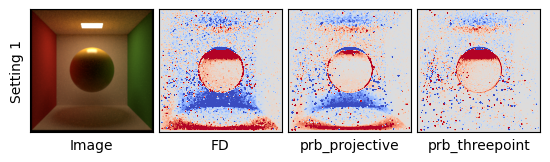

In [7]:
generate_figure(['prb_projective', 'prb_threepoint'], data, "", grad_projection='red')